# This notebook works through checking that the filtering done on an object does not result in a biased estimate of the orginal object profile
## That is, we wish to compare the output of ThumbStack when run with the two different filtering schemes and make sure it matches the profile we calculate on a single source with the same filtering

In [1]:
import sys
import os
sys.path.append('../../ThumbStack')
sys.path.append('../../LensQuEst')
import importlib

import flat_map
importlib.reload(flat_map)
from flat_map import *

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import fitsio
import pixell
importlib.reload(pixell)
from functools import partial

In [2]:
import matplotlib as mpl
# set some plotting defaults
mpl.rc(('lines', 'axes') , linewidth=2)
mpl.rc(('xtick', 'ytick'), labelsize=15)
mpl.rc(('xtick.major', 'ytick.major'), width=2)
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.serif'] = ['Times New Roman'] + mpl.rcParams['font.serif']
# mpl.rcParams["font.family"] = "Times New Roman" 
mpl.rcParams['text.usetex'] = True
# mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['font.size'] = 18
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [3]:
# map dimensions in degrees
sizeX = 0.5084
sizeY = 0.5084

# number of pixels for the flat map, let's do 0.5' pixels
nX = int(sizeX*60.*2.)
nY = int(sizeY*60.*2.)

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
# reminder: l=100 ~ 1 degree
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

In [4]:
print(nX, nY)

61 61


In [5]:
# single object's centroid
centroid = [0,0]
# order: [[ra_min, dec_max], [ra_max, dec_min]]
box = np.array([[centroid[1]-sizeX/2, centroid[0]+sizeX/2], [centroid[1]+sizeX/2, centroid[0]-sizeX/2]]) * utils.degree
resArcmin = 0.5  # map pixel size [arcmin]
shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='cea')

# create a mask that keeps the whole area
boxMask = enmap.ones(shape, wcs=wcs)

In [6]:
print(box, shape, boxMask.shape)
print(baseMap.data.shape)

[[-0.00443663  0.00443663]
 [ 0.00443663 -0.00443663]] (61, 61) (61, 61)
(61, 61)


(61, 61)


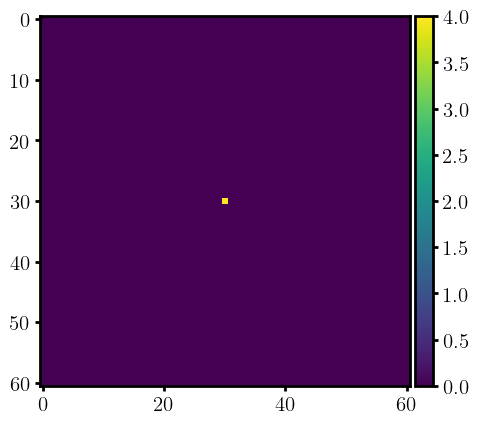

In [119]:
baseMap.data[31,31]
dmap = baseMap.copy()
dmap.data[30,30] = 4.
dmap.dataFourier = dmap.fourier()
print(dmap.data.shape)
im = plt.imshow(dmap.data)
colorbar(im)

In [120]:
# make single Gaussian
def fbeam(ell, fwhm):
    # takes a fwhm in arcmin
    fwhm_rad = fwhm * np.pi / 180. / 60.
    sigma_rad = fwhm_rad / np.sqrt(8.*np.log(2.))
    return np.exp(-0.5*(ell * sigma_rad)**2)

gaussfn = partial(fbeam, fwhm=5)
gmap = dmap.copy()
gmap.dataFourier = gmap.filterFourierIsotropic(fW=gaussfn)
gmap.data = gmap.inverseFourier()
gmap.data = np.hstack([gmap.data, np.zeros((61,1))])
print(gmap.data.shape)

(61, 61)


1.0


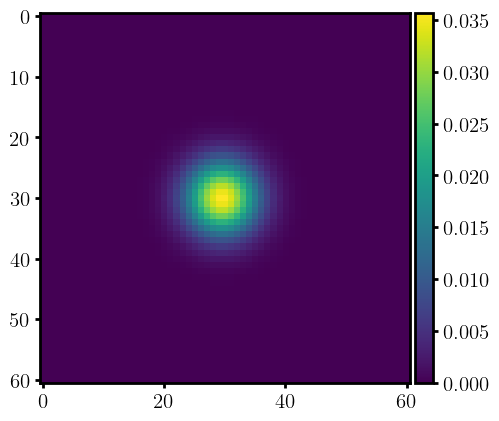

In [121]:
print(np.sum(boxMask.pixsizemap() * gmap.data * (180. * 60./np.pi)**2))
im = plt.imshow(gmap.data)
colorbar(im)

In [122]:
print(np.max(gmap.data))
sigma = 5 / np.sqrt(8*np.log(2))
print(1/ (2 * np.pi* sigma**2))

0.035651431439041
0.03530169602442425


In [123]:
bad_sigma = 5. / np.log(8*np.sqrt(2))
good_sigma = 5. / np.sqrt(8*np.log(2))
print(bad_sigma / good_sigma)
print(bad_sigma**2 / good_sigma**2)

0.9706534860434504
0.9421681899683026


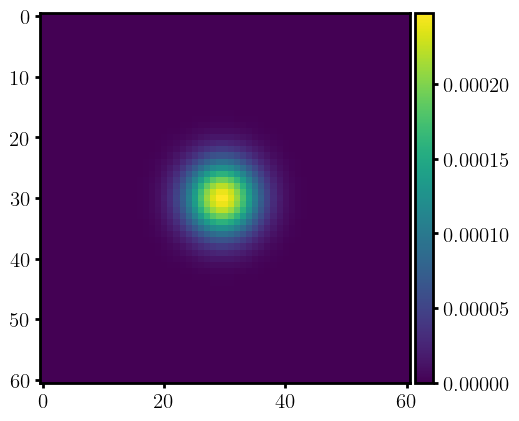

In [124]:
# normalize to match Will's profile
sigma = good_sigma
gmap.data *= 2 * np.pi * sigma**2
gmap.data *= 0.000245
gmap.dataFourier = gmap.fourier()
im = plt.imshow(gmap.data)
colorbar(im)

In [125]:
print(np.sum(boxMask.pixsizemap() * gmap.data * (180. * 60./np.pi)**2)/0.000245/(2*np.pi*sigma**2))
print(np.max(gmap.data))

1.0000000000000002
0.00024742722549426013


In [126]:
# add 1.6arcmin beam
beamfn = partial(fbeam, fwhm=1.6)
gmap.dataFourier = gmap.filterFourierIsotropic(fW=beamfn)
gmap.data = gmap.inverseFourier()
gmap.data = np.hstack([gmap.data, np.zeros((61,1))])

In [127]:
gmap.data.shape

(61, 61)

In [128]:
# gmap.data = np.hstack([gmap.data, np.zeros((61,1))])
print(gmap.data.shape)

(61, 61)


In [129]:
# make it an enmap
genmap = enmap.enmap(gmap.data, wcs)

In [130]:
genmap.shape

(61, 61)

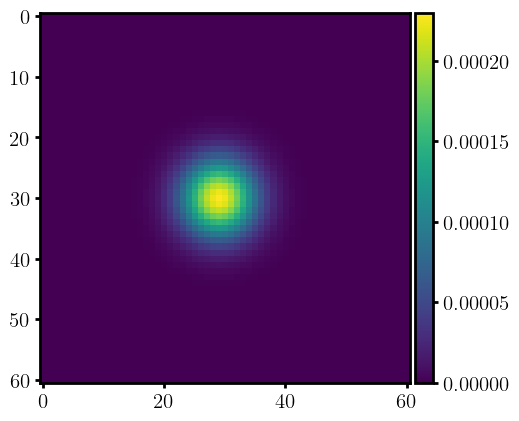

In [131]:
im = plt.imshow(genmap)
colorbar(im)

In [132]:
# get ra, dec for each pixel to help with aperture filters
opos = boxMask.posmap()
dec = opos[0,:,:]
ra = opos[1,:,:]
radius = np.sqrt(ra**2 + dec**2)
# exact angular area of a pixel [sr] (same for all pixels in CEA, not CAR)
pixArea = ra.area() / len(ra.flatten())

In [133]:
print(opos.shape, ra.shape, dec.shape, radius.shape)

(2, 61, 61) (61, 61) (61, 61) (61, 61)


In [75]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=20):
    import matplotlib.colors as colors
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

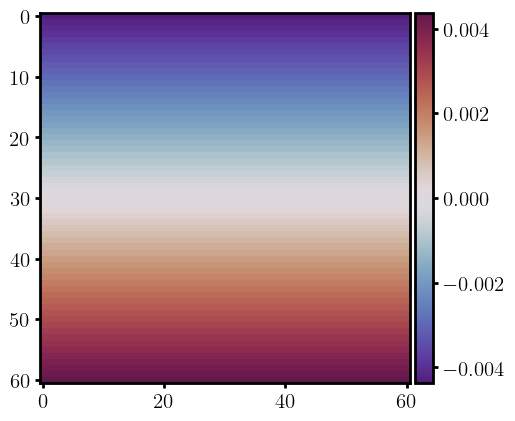

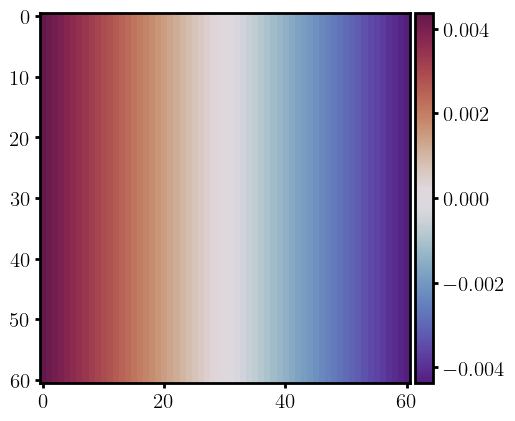

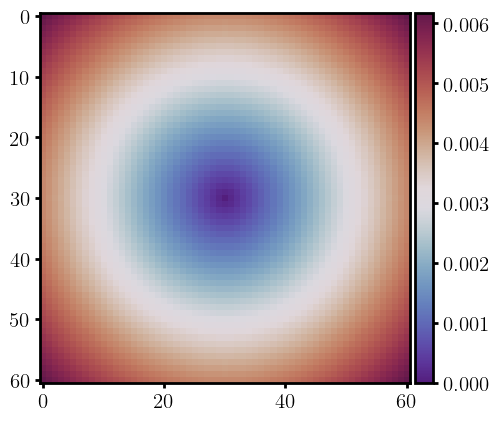

In [76]:
trunc_twilight = truncate_colormap(plt.get_cmap('twilight_shifted'), 0.1, 0.9, 20)
for m in [dec, ra, radius]:
    f = plt.figure()
    im = plt.imshow(m, cmap=trunc_twilight)
    colorbar(im)

In [77]:
print(ra[30,30], dec[30,30])

0.0 0.0


In [78]:
print(ra.shape, pixArea / (np.pi / 180 / 60)**2)

(61, 61) 0.24999999999999997


In [79]:
# Setup filtering

from scipy.special import erf

def hpf_theo(ell):
    loc = 1500
    half_width = 50

    return erf(2/np.sqrt(2)/half_width*(ell-loc))/2 + 0.5

def lpf_theo(ell):
    loc = 1000
    half_width = 50

    return -1 * erf(2/np.sqrt(2)/half_width*(ell-loc))/2 + 0.5

def hpf_will(ell):
    # do piecewise filtering
    low_ell = ell[ell<2350]
    mid_ell = ell[np.logical_and(2350<ell, ell<2500)]
    hi_ell = ell[ell>2500]
    low_filt = np.zeros_like(low_ell)
    mid_filt = np.sin((mid_ell-2350) * np.pi/300.)
    hi_filt = np.ones_like(hi_ell)
    tot_filt = np.concatenate([low_filt, mid_filt, hi_filt])
    
    return tot_filt

def lpf_will(ell):
    # do piecewise filtering
    low_ell = ell[ell<2000]
    mid_ell = ell[np.logical_and(2000<ell, ell<2150)]
    hi_ell = ell[ell>2150]
    low_filt = np.ones_like(low_ell)
    mid_filt = np.cos((mid_ell-2000) * np.pi/300.)
    hi_filt = np.zeros_like(hi_ell)
    tot_filt = np.concatenate([low_filt, mid_filt, hi_filt])

    return tot_filt

In [80]:
def make_filtered_map(flatmap_list, filt):
    filter_map_list = []
    for flatmap in flatmap_list:
        flatmap.dataFourier = flatmap.fourier(flatmap.data)
        map_filt_fourier = flatmap.filterFourierIsotropic(fW=filt)
        map_filt_data = flatmap.inverseFourier(map_filt_fourier)
        filt_flat_map = baseMap.copy()
        filt_flat_map.data = map_filt_data
        filt_flat_map.dataFourier = map_filt_fourier
        filt_flat_map.data = np.hstack([np.zeros((61,1)), filt_flat_map.data])
        print(filt_flat_map.data.shape)
        filt_enmap = enmap.enmap(filt_flat_map.data, wcs)
        filter_map_list.append(filt_enmap)
    
    return filter_map_list

In [81]:
lpf_t = make_filtered_map([gmap], filt=lpf_theo)[0]
hpf_t = make_filtered_map([gmap], filt=hpf_theo)[0]
lpf_w = make_filtered_map([gmap], filt=lpf_will)[0]
hpf_w = make_filtered_map([gmap], filt=hpf_will)[0]

(61, 61)
(61, 61)
(61, 61)
(61, 61)


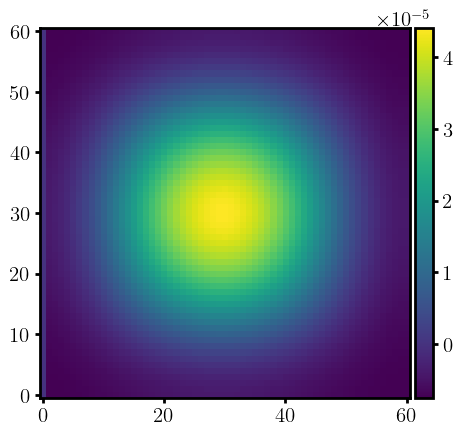

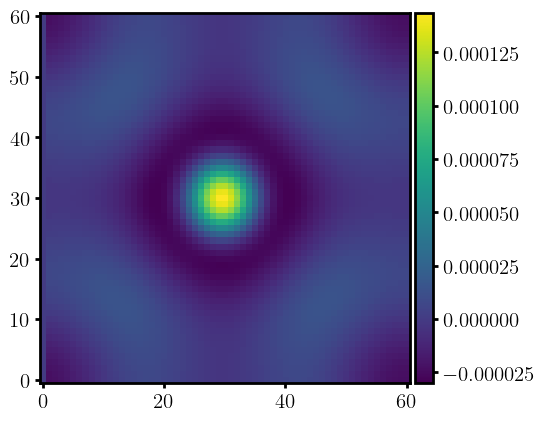

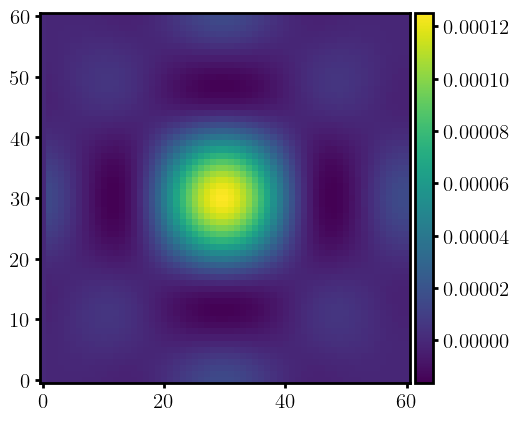

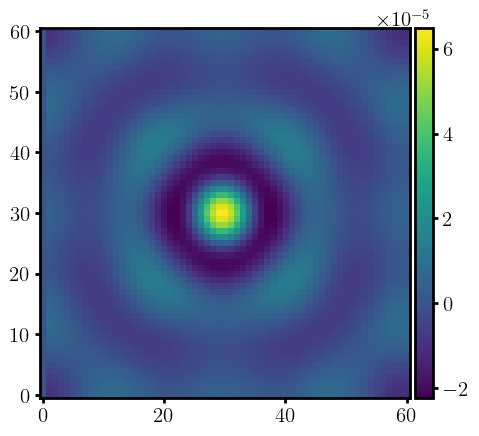

In [82]:
maps = [lpf_t, hpf_t, lpf_w, hpf_w]
for map in maps:
    f = plt.figure()
    im = plt.imshow(map.data, origin='lower')
    colorbar(im)

In [83]:
RAp = np.linspace(1., 6., 9) # aperture radii for radial profile
rad2arcmin = 180. * 60. / np.pi
ring_areas = [] # will be in arcmin^2
for iRAp in range(9):
        if iRAp == 0:
            r0 = 0
        else:
            r0 = RAp[iRAp - 1] / 60. * np.pi / 180.
        r1 = RAp[iRAp] / 60. * np.pi / 180.
        inRing = 1.*(radius>r0)*(radius<=r1)
        # exact angular area of ring [sr]
        ringArea = np.sum(inRing) * pixArea
        print(ringArea * rad2arcmin**2)
        ring_areas.append(ringArea * rad2arcmin**2)

2.2499999999999996
6.749999999999998
7.999999999999998
7.999999999999998
11.499999999999998
18.499999999999996
17.999999999999996
15.999999999999996
20.499999999999996


In [84]:
def calc_profile(enmap):
    filt_profile = []
    f, axs = plt.subplots(3,3, figsize=(10,9))
    for iRAp in range(9):
        i = iRAp//3
        j = iRAp%3
        if iRAp == 0:
            r0 = 0
        else:
            r0 = RAp[iRAp - 1] / 60. * np.pi / 180.
        r1 = RAp[iRAp] / 60. * np.pi / 180.
        inRing = 1.*(radius>r0)*(radius<=r1)
        # exact angular area of ring [sr]
        ringArea = np.sum(inRing) * pixArea
        print(ringArea * rad2arcmin**2)
        filterW = inRing
        filtArea = ringArea
        filtMap = np.sum(pixArea * filterW * enmap)
        im = axs[i,j].imshow(filterW * enmap)
        colorbar(im)
        filt_profile.append(filtMap)
    filt_profile = np.array(filt_profile)
    print(filt_profile)

    return filt_profile

2.2499999999999996
6.749999999999998
7.999999999999998
7.999999999999998
11.499999999999998
18.499999999999996
17.999999999999996
15.999999999999996
20.499999999999996
[ 2.53289194e-11  6.18711018e-11  4.89863628e-11  2.87800925e-11
  1.67278064e-11 -1.02061476e-11 -3.23760916e-11 -3.60224198e-11
 -4.76091677e-11]
2.2499999999999996
6.749999999999998
7.999999999999998
7.999999999999998
11.499999999999998
18.499999999999996
17.999999999999996
15.999999999999996
20.499999999999996
[ 1.09573424e-11  2.32554872e-11  1.19344870e-11  3.08894802e-13
 -1.13543537e-11 -2.97328236e-11 -2.78762810e-11 -1.80956727e-11
 -1.25564805e-11]


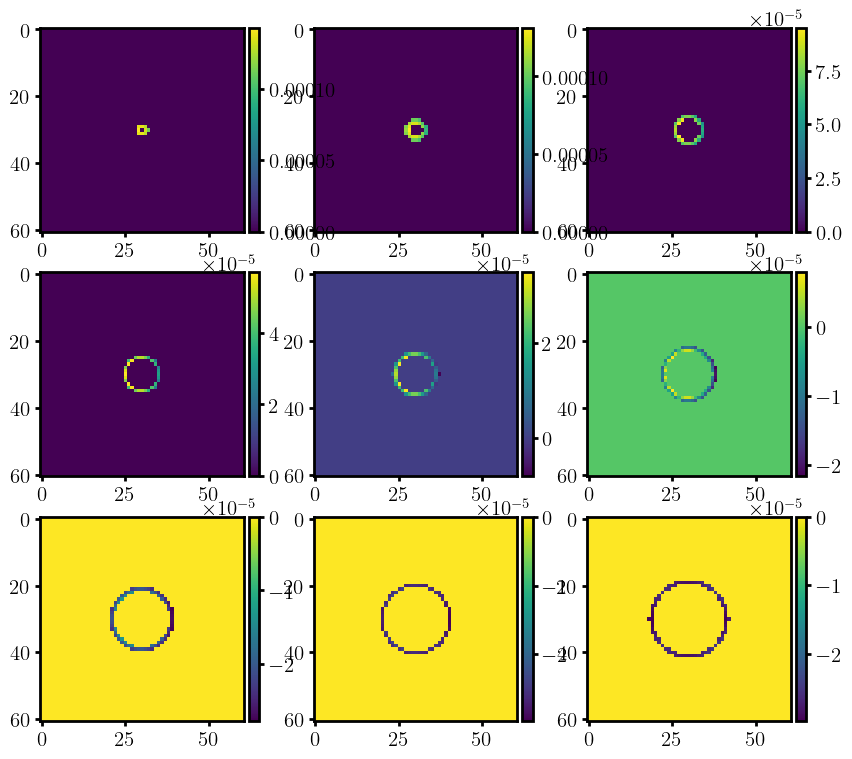

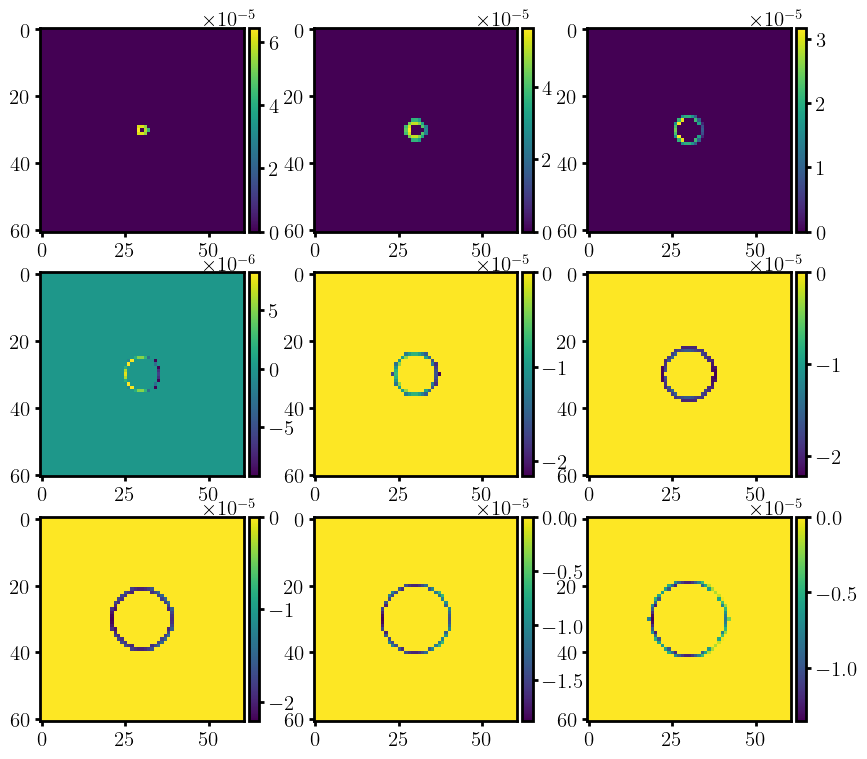

In [134]:
profile_list = []
for emap in (hpf_t, hpf_w):
    profile= calc_profile(emap)
    profile_list.append(profile)

In [135]:
# divide by ring area to get mean tau
r = RAp.copy()
# areas = r.copy()
# for j in range(len(r)):
#     if j == 0:
#         areas[j] = np.pi * r[j]**2
#     else:
#         areas[j] = np.pi * (r[j]**2 - r[j-1]**2)
# print(areas)
def plot_mean_tau(filt_profile, **kwargs):
    print(filt_profile)
    filt_profile = np.array(filt_profile)
    filt_prof_dens = filt_profile * rad2arcmin**2 / ring_areas
    print(filt_prof_dens)
    plt.plot(r, filt_prof_dens, **kwargs)

[ 2.53289194e-11  6.18711018e-11  4.89863628e-11  2.87800925e-11
  1.67278064e-11 -1.02061476e-11 -3.23760916e-11 -3.60224198e-11
 -4.76091677e-11]
[ 1.33039900e-04  1.08325784e-04  7.23657343e-05  4.25157617e-05
  1.71905162e-05 -6.51985416e-06 -2.12568878e-05 -2.66072914e-05
 -2.74463435e-05]
[ 1.09573424e-11  2.32554872e-11  1.19344870e-11  3.08894802e-13
 -1.13543537e-11 -2.97328236e-11 -2.78762810e-11 -1.80956727e-11
 -1.25564805e-11]
[ 5.75533330e-05  4.07164060e-05  1.76303744e-05  4.56318817e-07
 -1.16684278e-05 -1.89938145e-05 -1.83024865e-05 -1.33660326e-05
 -7.23872087e-06]


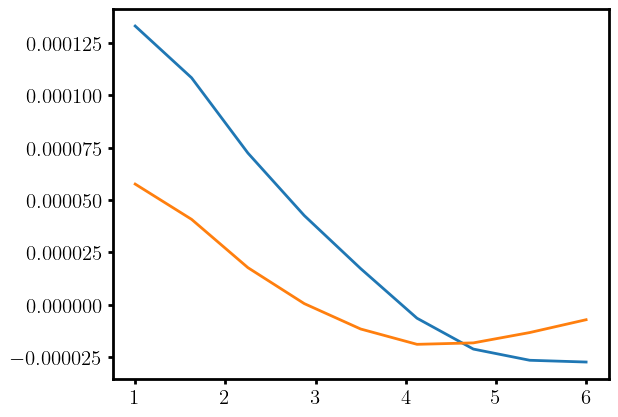

In [136]:
f = plt.figure()
for prof in profile_list:
    plot_mean_tau(prof)

In [137]:
ts_theo = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10s10_tau-fwhm_renorm2.45e-4_v3_c-1.0_theofilt/tauring_tau_ti_uniformweight_measured.txt')
ts_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10s10_tau-fwhm_renorm2.45e-4_v3_c-1.0_willfilt/tauring_tau_ti_uniformweight_measured.txt')

In [138]:
profile_list.append(ts_theo[:,1])
profile_list.append(ts_will[:,1])

[ 2.53289194e-11  6.18711018e-11  4.89863628e-11  2.87800925e-11
  1.67278064e-11 -1.02061476e-11 -3.23760916e-11 -3.60224198e-11
 -4.76091677e-11]
[ 1.33039900e-04  1.08325784e-04  7.23657343e-05  4.25157617e-05
  1.71905162e-05 -6.51985416e-06 -2.12568878e-05 -2.66072914e-05
 -2.74463435e-05]
[ 1.09573424e-11  2.32554872e-11  1.19344870e-11  3.08894802e-13
 -1.13543537e-11 -2.97328236e-11 -2.78762810e-11 -1.80956727e-11
 -1.25564805e-11]
[ 5.75533330e-05  4.07164060e-05  1.76303744e-05  4.56318817e-07
 -1.16684278e-05 -1.89938145e-05 -1.83024865e-05 -1.33660326e-05
 -7.23872087e-06]
[ 5.89234521e-11  9.68641491e-11  8.52535349e-11  7.33121399e-11
  2.56785308e-11 -2.10859594e-11 -5.96426893e-11 -9.51563087e-11
 -9.88670810e-11]
[ 3.09494852e-04  1.69592663e-04  1.25941881e-04  1.08301301e-04
  2.63888277e-05 -1.34700561e-05 -3.91590798e-05 -7.02854403e-05
 -5.69961625e-05]
[ 2.56051167e-11  3.68862062e-11  2.36732078e-11  4.03450278e-12
 -2.19884551e-11 -4.61037196e-11 -4.98102552e-1

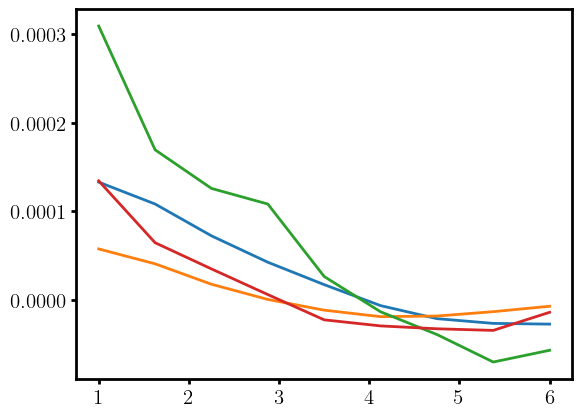

In [139]:
f = plt.figure()
for prof in profile_list:
    plot_mean_tau(prof)

[ 1.09573424e-11  2.32554872e-11  1.19344870e-11  3.08894802e-13
 -1.13543537e-11 -2.97328236e-11 -2.78762810e-11 -1.80956727e-11
 -1.25564805e-11]
[ 5.75533330e-05  4.07164060e-05  1.76303744e-05  4.56318817e-07
 -1.16684278e-05 -1.89938145e-05 -1.83024865e-05 -1.33660326e-05
 -7.23872087e-06]


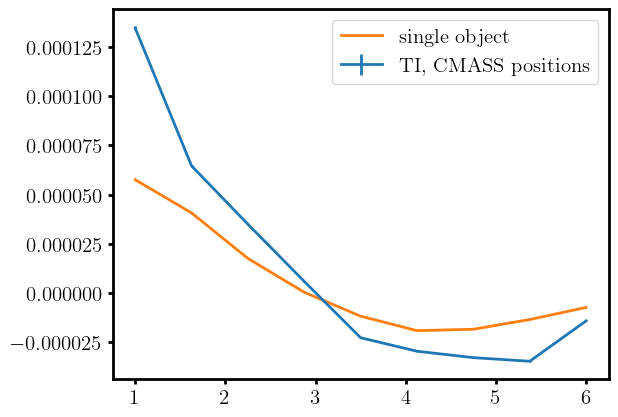

In [140]:
f = plt.figure()

plt.errorbar(r, ts_will[:,1]* rad2arcmin**2 / ring_areas, ts_will[:,2]* rad2arcmin**2 / ring_areas, label='TI, CMASS positions')
plot_mean_tau(profile_list[1], label='single object')
plt.legend()

[ 2.53289194e-11  6.18711018e-11  4.89863628e-11  2.87800925e-11
  1.67278064e-11 -1.02061476e-11 -3.23760916e-11 -3.60224198e-11
 -4.76091677e-11]
[ 1.33039900e-04  1.08325784e-04  7.23657343e-05  4.25157617e-05
  1.71905162e-05 -6.51985416e-06 -2.12568878e-05 -2.66072914e-05
 -2.74463435e-05]


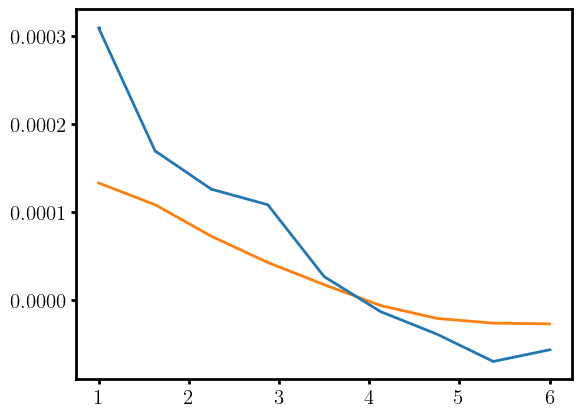

In [141]:
f = plt.figure()

plt.errorbar(r, ts_theo[:,1]* rad2arcmin**2 / ring_areas, ts_theo[:,2]* rad2arcmin**2 / ring_areas)
plot_mean_tau(profile_list[0])

## the discrepancy is prob due to overlapping sources in the thumbstack stack
## the discrepancy is within the advact 1sigma stat error bars
## should be accounted for or discussed? Or stick to "accounting for overlapping is future work"...?

### TI

In [142]:
ts_rand_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4_c-1.0_willfilt/tauring_tau_ti_uniformweight_measured.txt')
ts_grid_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/grid_10x10_10x10src_periodic_v2_renorm2.45e-04_c-1.0_beam1.6_willfilt/tauring_tau_ti_uniformweight_measured.txt')

[ 1.09573424e-11  2.32554872e-11  1.19344870e-11  3.08894802e-13
 -1.13543537e-11 -2.97328236e-11 -2.78762810e-11 -1.80956727e-11
 -1.25564805e-11]
[ 5.75533330e-05  4.07164060e-05  1.76303744e-05  4.56318817e-07
 -1.16684278e-05 -1.89938145e-05 -1.83024865e-05 -1.33660326e-05
 -7.23872087e-06]


Text(0, 0.5, '$\\langle \\tau \\rangle$')

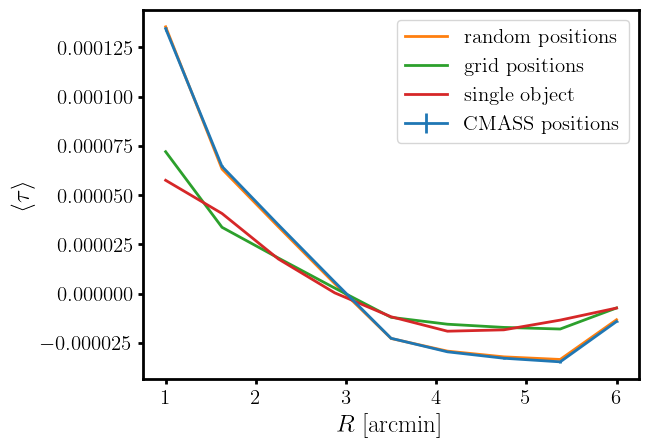

In [143]:
f = plt.figure()

plt.errorbar(r, ts_will[:,1]* rad2arcmin**2 / ring_areas, ts_will[:,2]* rad2arcmin**2 / ring_areas, label='CMASS positions')
plt.plot(r, ts_rand_will[:,1] * rad2arcmin**2 / ring_areas, label='random positions')
plt.plot(r, ts_grid_will[:,1] * rad2arcmin**2 / ring_areas, label='grid positions')
plot_mean_tau(profile_list[1], label='single object')
plt.legend()
plt.xlabel(r'$R$ [arcmin]')
plt.ylabel(r'$\langle \tau \rangle$')

### Sgn

ValueError: x and y must have same first dimension, but have shapes (9,) and (1,)

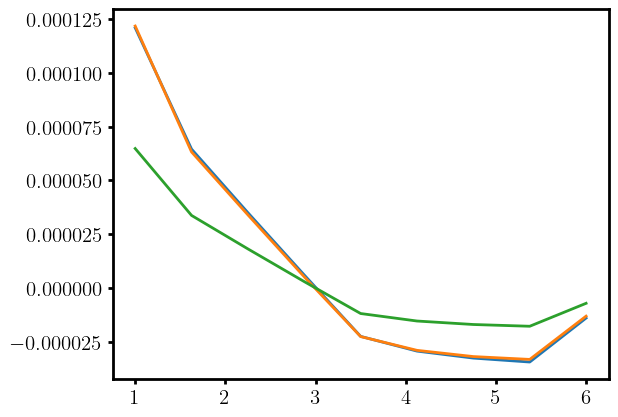

In [163]:
ts_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10s10_tau-fwhm_renorm2.45e-4_v3_c-1.0_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
ts_rand_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4_c-1.0_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
ts_grid_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/grid_10x10_10x10src_periodic_v2_renorm2.45e-04_c-1.0_beam1.6_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
f, ax = plt.subplots(1,1)

ax.errorbar(r, ts_will[:,1]* rad2arcmin**2 / ring_areas, ts_will[:,2]* rad2arcmin**2 / ring_areas, label='CMASS positions')
ax.plot(r, ts_rand_will[:,1] * rad2arcmin**2 / ring_areas, label='random positions')
ax.plot(r, ts_grid_will[:,1] * rad2arcmin**2 / ring_areas, label='grid positions')
plot_mean_tau(r, profile_list[1] * rad2arcmin**2 / ring_areas, ax=ax, label='single object')
ax.legend()
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
ax.set_ylim(-0.00005, 0.000125)

[ 1.09573424e-11  2.32554872e-11  1.19344870e-11  3.08894802e-13
 -1.13543537e-11 -2.97328236e-11 -2.78762810e-11 -1.80956727e-11
 -1.25564805e-11]
[ 5.75533330e-05  4.07164060e-05  1.76303744e-05  4.56318817e-07
 -1.16684278e-05 -1.89938145e-05 -1.83024865e-05 -1.33660326e-05
 -7.23872087e-06]


(-5e-05, 0.00015)

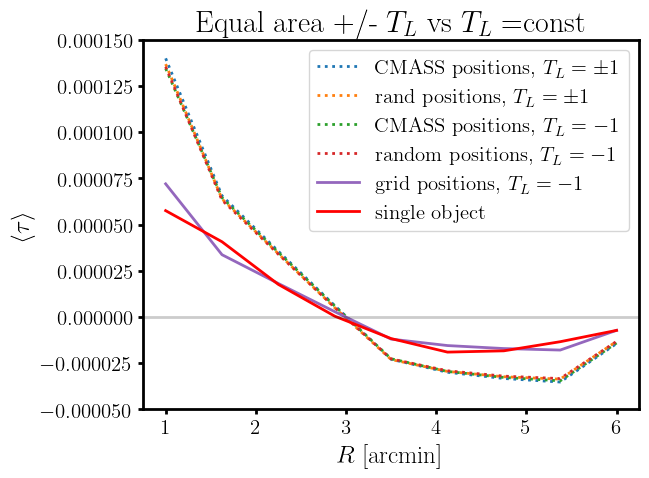

In [145]:
ts_cmass_quad = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10x10_tau-fwhm5_renorm2.45e-4_v4_quad_weighted_beam1.6_wfilt_eqsgn/tauring_tau_ti_uniformweight_measured.txt')
ts_rand_quad = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4_quad_weighted_beam1.6_wfilt/tauring_tau_ti_uniformweight_measured.txt')

f = plt.figure()
r = RAp
plt.plot(r, -ts_cmass_quad[:,1]* rad2arcmin**2 / ring_areas, label=r'CMASS positions, $T_L=\pm1$', ls=':')
# plt.plot(r, ts_cmass_quad[:,1] * rad2arcmin**2 / ring_areas, label='random positions')
plt.plot(r, ts_rand_quad[:,1] * rad2arcmin**2 / ring_areas, label=r'rand positions, $T_L=\pm1$', ls=':')
plt.plot(r, ts_will[:,1]* rad2arcmin**2 / ring_areas, label=r'CMASS positions, $T_L=-1$', ls=':')
plt.plot(r, ts_rand_will[:,1] * rad2arcmin**2 / ring_areas, label=r'random positions, $T_L=-1$', ls=':')
plt.plot(r, ts_grid_will[:,1] * rad2arcmin**2 / ring_areas, label=r'grid positions, $T_L=-1$')
plot_mean_tau(profile_list[1], label='single object', c='r')
plt.title(r'Equal area +/- $T_L$ vs $T_L=$const')
plt.axhline(0, c='k', alpha=0.2)
plt.legend()
plt.xlabel(r'$R$ [arcmin]')
plt.ylabel(r'$\langle \tau \rangle$')
plt.ylim(-0.00005, 0.000150)

## Hmm, the profile seems to be just measuring the amplitude, otherwise would expect the CMASS/randoms to have broader distribution. Let's investigate the profile of two overlapping objects with varying separation distance. Does the filter kill the contribution to the tails and just leaves the amplitude boost?

In [154]:
def make_basemap():
    # map dimensions in degrees
    sizeX = 0.5084
    sizeY = 0.5084
    
    # number of pixels for the flat map, let's do 0.5' pixels
    nX = int(sizeX*60.*2.)
    nY = int(sizeY*60.*2.)
    
    # basic map object
    baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

    # single object's centroid
    centroid = [0,0]
    # order: [[ra_min, dec_max], [ra_max, dec_min]]
    box = np.array([[centroid[1]-sizeX/2, centroid[0]+sizeX/2], [centroid[1]+sizeX/2, centroid[0]-sizeX/2]]) * utils.degree
    resArcmin = 0.5  # map pixel size [arcmin]
    shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='cea')
    
    # create a mask that keeps the whole area
    boxMask = enmap.ones(shape, wcs=wcs)

    return baseMap, boxMask, wcs

In [155]:
def make_ptsrc_map(baseMap, plot=True):
    """make stamp with 2 Dirac functions separated by sep pixels
    sep: separation of the 2 centroids in pixels (i.e. [0.5arcmin])
    """
    stampcen_x, stampcen_y = 30, 30
    dmap = baseMap.copy()
    dmap.data[stampcen_y, stampcen_y] += 1.
    dmap.dataFourier = dmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(dmap.data)
        colorbar(im)

    return dmap

In [156]:
def make_2ptsrc_map(baseMap, sep=0, plot=True):
    """make stamp with 2 Dirac functions separated by sep pixels
    sep: separation of the 2 centroids in pixels (i.e. [0.5arcmin])
    """
    stampcen_x, stampcen_y = 30, 30
    pt1_cen_x = int(np.floor(stampcen_x))
    pt2_cen_x = int(np.ceil(stampcen_x + sep))
    dmap = baseMap.copy()
    dmap.data[stampcen_y, pt1_cen_x] += 1.
    dmap.data[stampcen_y, pt2_cen_x] += 1.
    dmap.dataFourier = dmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(dmap.data)
        colorbar(im)

    return dmap

In [157]:
# make single Gaussian
def fbeam(ell, fwhm):
    # takes a fwhm in arcmin
    fwhm_rad = fwhm * np.pi / 180. / 60.
    sigma_rad = fwhm_rad / np.sqrt(8.*np.log(2.))
    return np.exp(-0.5*(ell * sigma_rad)**2)

def gaussify_map(baseMap, fwhm=5., renorm=2.45e-4, plot=True):
    gaussfn = partial(fbeam, fwhm=fwhm)
    gmap = baseMap.copy()
    gmap.dataFourier = gmap.filterFourierIsotropic(fW=gaussfn)
    gmap.data = gmap.inverseFourier()
    # normalize
    sigma = fwhm / np.sqrt(8.*np.log(2.))
    gmap.data *= 2. * np.pi * sigma**2
    gmap.data *= renorm
    gmap.dataFourier = gmap.fourier()
    # add 1.6arcmin beam
    beamfn = partial(fbeam, fwhm=1.6)
    gmap.dataFourier = gmap.filterFourierIsotropic(fW=beamfn)
    gmap.data = gmap.inverseFourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(gmap.data)
        colorbar(im)

    return gmap
    # gmap.data = np.hstack([gmap.data, np.zeros((61,1))])
    # print(gmap.data.shape)

In [158]:
# Setup filtering
from scipy.special import erf

def hpf_theo(ell):
    loc = 1500
    half_width = 50

    return erf(2/np.sqrt(2)/half_width*(ell-loc))/2 + 0.5

def lpf_theo(ell):
    loc = 1000
    half_width = 50

    return -1 * erf(2/np.sqrt(2)/half_width*(ell-loc))/2 + 0.5

def hpf_will(ell):
    # do piecewise filtering
    low_ell = ell[ell<2350]
    mid_ell = ell[np.logical_and(2350<ell, ell<2500)]
    hi_ell = ell[ell>2500]
    low_filt = np.zeros_like(low_ell)
    mid_filt = np.sin((mid_ell-2350) * np.pi/300.)
    hi_filt = np.ones_like(hi_ell)
    tot_filt = np.concatenate([low_filt, mid_filt, hi_filt])
    
    return tot_filt

def lpf_will(ell):
    # do piecewise filtering
    low_ell = ell[ell<2000]
    mid_ell = ell[np.logical_and(2000<ell, ell<2150)]
    hi_ell = ell[ell>2150]
    low_filt = np.ones_like(low_ell)
    mid_filt = np.cos((mid_ell-2000) * np.pi/300.)
    hi_filt = np.zeros_like(hi_ell)
    tot_filt = np.concatenate([low_filt, mid_filt, hi_filt])

    return tot_filt

In [159]:
def make_filtered_enmap(flatmap, filt, wcs, plot=True):
    filt_map = flatmap.copy()
    filt_map.dataFourier = filt_map.filterFourierIsotropic(fW=filt)
    filt_map.data = filt_map.inverseFourier()
    filt_map.data = np.hstack([np.zeros((61,1)), filt_map.data]) # map loses a column during filtering
    filt_enmap = enmap.enmap(filt_map.data, wcs)
    if plot:
        f = plt.figure()
        im = plt.imshow(filt_map.data)
        colorbar(im)

    return filt_enmap

In [160]:
def calc_profile(filt_enmap, boxMask):
    # get ra, dec for each pixel to help with aperture filters
    opos = boxMask.posmap()
    dec = opos[0,:,:]
    ra = opos[1,:,:]
    radius = np.sqrt(ra**2 + dec**2)
    # exact angular area of a pixel [sr] (same for all pixels in CEA, not CAR)
    pixArea = ra.area() / len(ra.flatten())
    RAp = np.linspace(1., 6., 9) # aperture radii for radial profile
    rad2arcmin = 180. * 60. / np.pi
    ring_areas = []
    filt_profile = []
    for iRAp in range(9):
        if iRAp == 0:
            r0 = 0
        else:
            r0 = RAp[iRAp - 1] / 60. * np.pi / 180.
        r1 = RAp[iRAp] / 60. * np.pi / 180.
        inRing = 1.*(radius>=r0)*(radius<r1)
        # exact angular area of ring [sr]
        ringArea = np.sum(inRing) * pixArea
        ring_areas.append(ringArea * rad2arcmin**2) # get exact ring areas for making density profile
        filtMap = np.sum(pixArea * inRing * filt_enmap)
        filt_profile.append(filtMap)
    filt_dens_profile = np.array(filt_profile) * rad2arcmin**2 / ring_areas

    return RAp, filt_dens_profile, ring_areas

In [161]:
def plot_mean_tau(RAp, filt_dens_profile, ax=None, **kwargs):    
    if ax==None:
        f, ax = plt.subplots(1,1)
    ax.plot(RAp, filt_dens_profile, **kwargs)

(-5e-05, 0.000125)

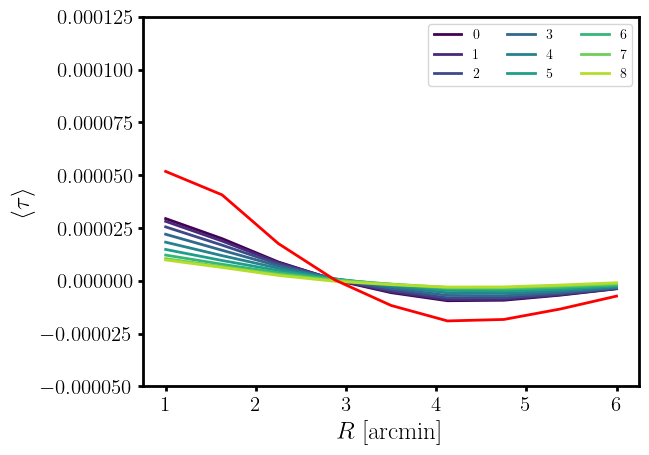

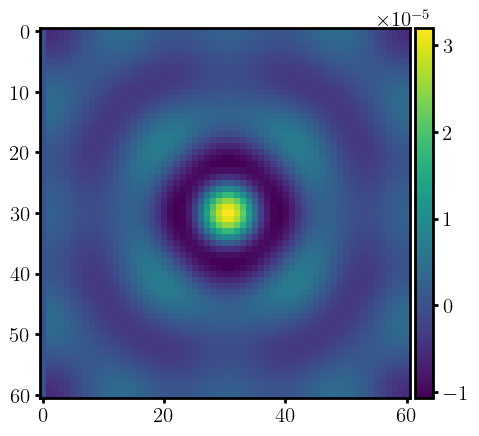

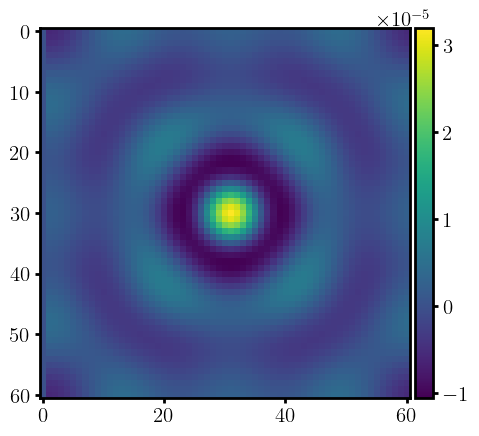

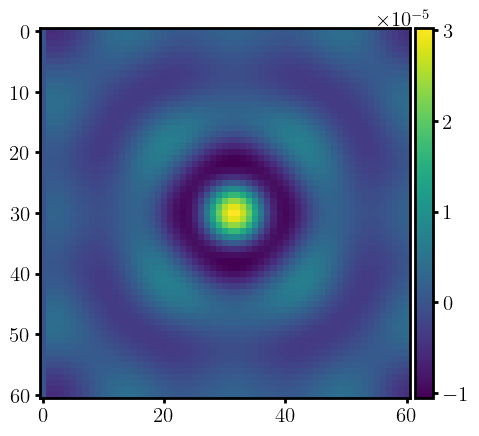

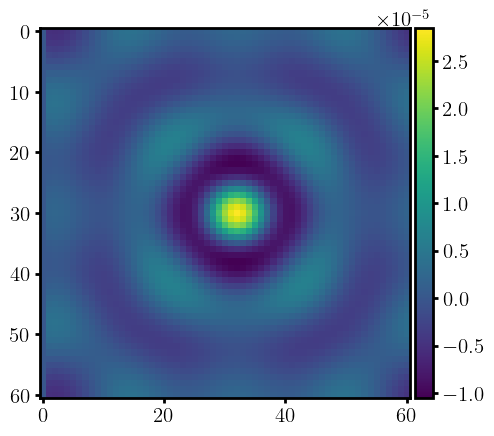

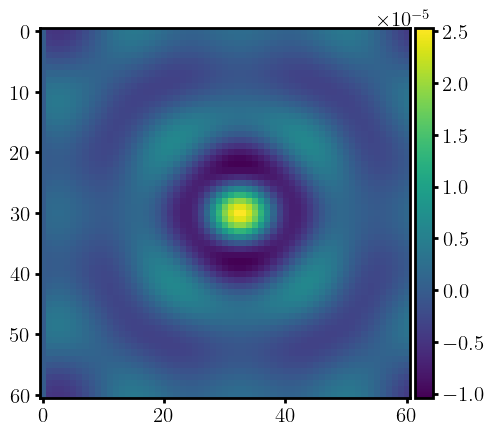

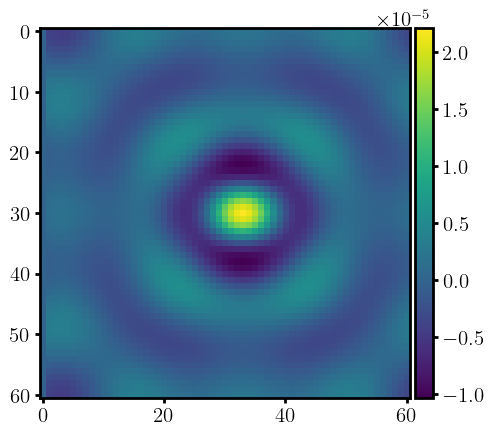

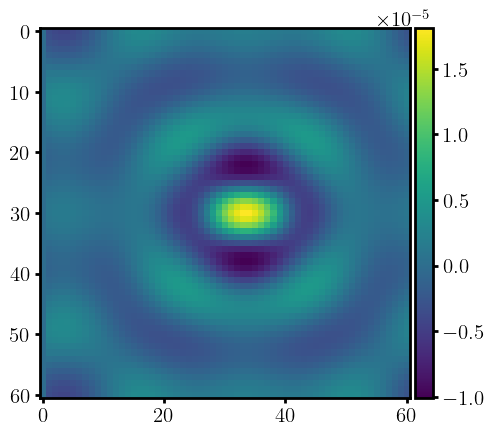

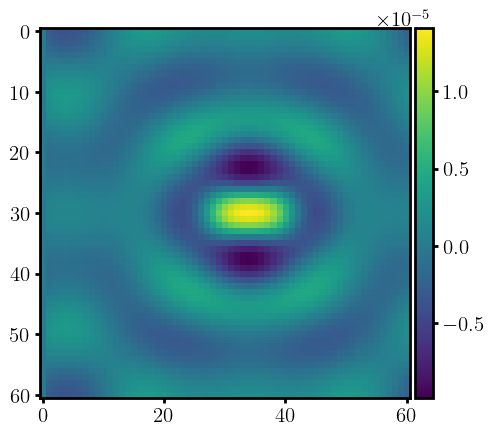

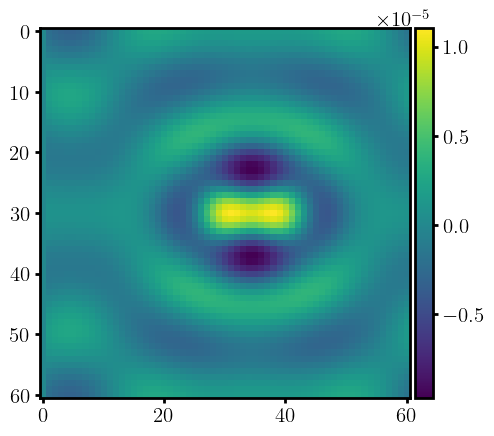

In [162]:
n = 9
f, ax = plt.subplots(1,1)
for i in range(n):
    baseMap, boxMask, wcs = make_basemap()
    dmap = make_2ptsrc_map(baseMap, sep=i, plot=False)
    gmap = gaussify_map(dmap, plot=False)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=1)
    RAp, filt_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_profile, ax=ax, c=plt.get_cmap('viridis')(i/n), label=str(i))
ax.plot(RAp, profile_list[1]  * rad2arcmin**2 / ring_areas, c='r')
ax.set_ylim(-0.00005, 0.000125)
ax.legend(ncol=3, fontsize=10)
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
ax.set_ylim(-0.00005, 0.000125)

In [146]:
print(profile_list[1])

[ 1.13918615e-11  2.37638559e-11  1.23452626e-11  4.12289610e-13
 -1.15454063e-11 -3.05683879e-11 -2.87689139e-11 -1.87598047e-11
 -1.31202146e-11]


## Check ratio between profiles

Text(0, 0.5, '$\\langle \\tau \\rangle$')

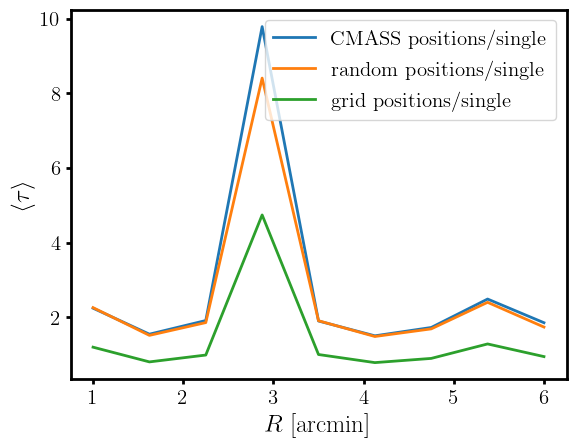

In [220]:
ts_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10s10_tau-fwhm_renorm2.45e-4_v3_c-1.0_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
ts_rand_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4_c-1.0_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
ts_grid_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/grid_10x10_10x10src_periodic_v2_renorm2.45e-04_c-1.0_beam1.6_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
f, ax = plt.subplots(1,1)

ax.plot(r, ts_will[:,1] / profile_list[1], label='CMASS positions/single')
ax.plot(r, ts_rand_will[:,1] / profile_list[1], label='random positions/single')
ax.plot(r, ts_grid_will[:,1] / profile_list[1], label='grid positions/single')
# plot_mean_tau(r, profile_list[1] * rad2arcmin**2 / ring_areas, ax=ax, label='single object')
ax.legend()
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
ax.set_ylim(-0.00005, 0.000125)

(0.5, 3.0)

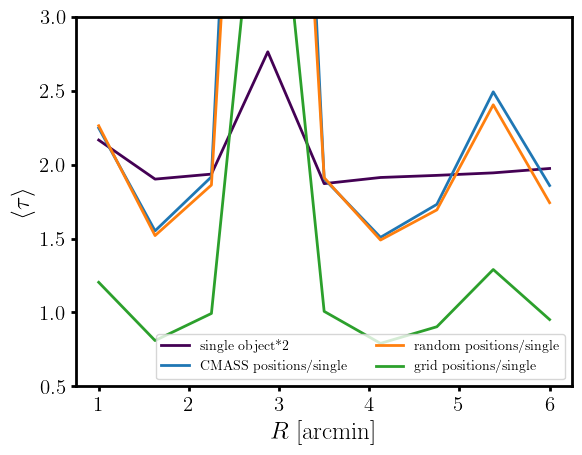

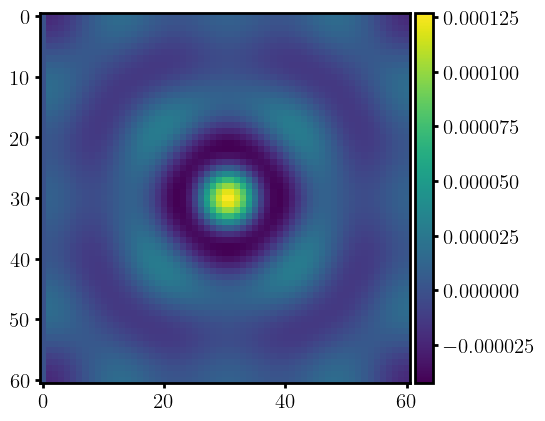

In [221]:
n = 1
f, ax = plt.subplots(1,1)
for i in range(n):
    baseMap, boxMask, wcs = make_basemap()
    dmap = make_2ptsrc_map(baseMap, sep=i, plot=False)
    gmap = gaussify_map(dmap, plot=False)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=1)
    RAp, filt_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_profile/(profile_list[1]  * rad2arcmin**2 / ring_areas), ax=ax, c=plt.get_cmap('viridis')(i/n), label='single object*2')
# ax.plot(RAp, profile_list[1]  * rad2arcmin**2 / ring_areas, c='r')
ax.plot(r, ts_will[:,1] / profile_list[1], label='CMASS positions/single')
ax.plot(r, ts_rand_will[:,1] / profile_list[1], label='random positions/single')
ax.plot(r, ts_grid_will[:,1] / profile_list[1], label='grid positions/single')
ax.legend(ncol=2, fontsize=10)
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
ax.set_ylim(0.5,3)

# Checking input CMASS and random maps

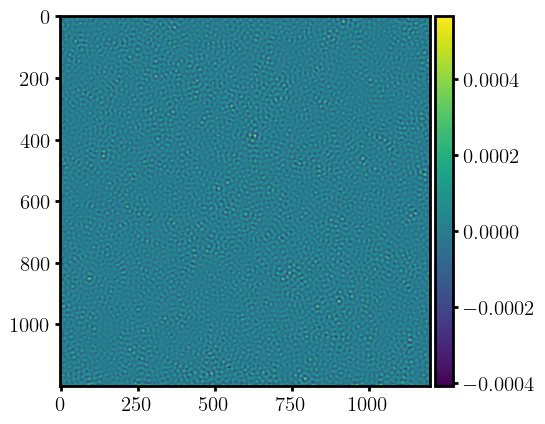

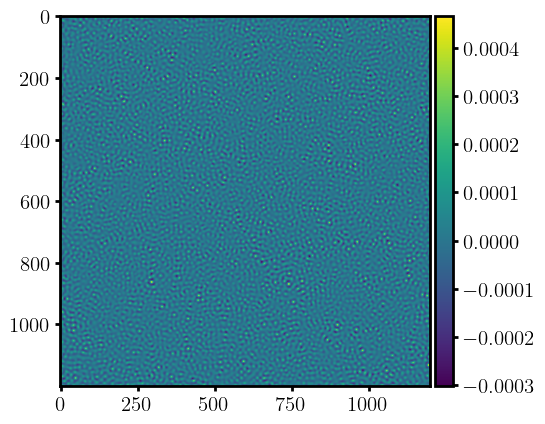

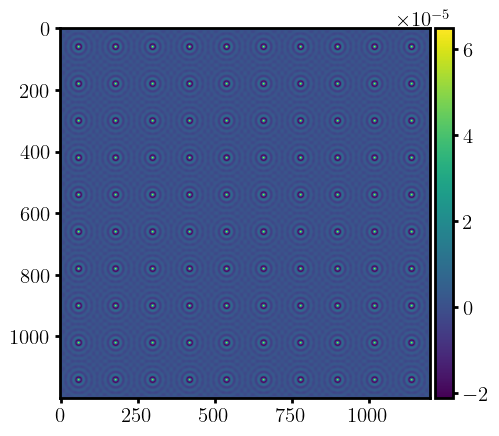

In [218]:
import fitsio

cmass_tau_hpf = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_tau-fwhm5_v3/cmass_m_10x10_tau-fwhm5_renorm2.45e-4_v3_beam1.6_hpf2425w_image.fits')
rand_tau_hpf = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4_c-1.0_beam1.6_hpf2425w_image.fits')
grid_tau_hpf = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/grid_10x10_10x10src_periodic_v2/grid_10x10_10x10src_periodic_v2_renorm2.45e-04_c-1.0_beam1.6_hpf2425w_image.fits')
f= plt.figure()
im = plt.imshow(cmass_tau_hpf)
colorbar(im)
f = plt.figure()
im = plt.imshow(rand_tau_hpf)
colorbar(im)
f = plt.figure()
im = plt.imshow(grid_tau_hpf)
colorbar(im)

In [219]:
print(np.mean(cmass_tau_hpf))
print(np.mean(rand_tau_hpf))
print(np.mean(grid_tau_hpf))

1.927470528863119e-23
-3.854941057726238e-23
-9.185601739113302e-24


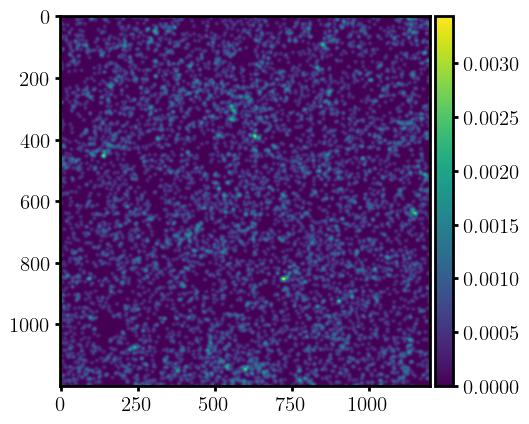

In [208]:
cmass_tau = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_tau-fwhm5_v3/cmass_m_10x10_tau-fwhm5_renorm2.45e-4_v3_image.fits')
im = plt.imshow(cmass_tau)
colorbar(im)

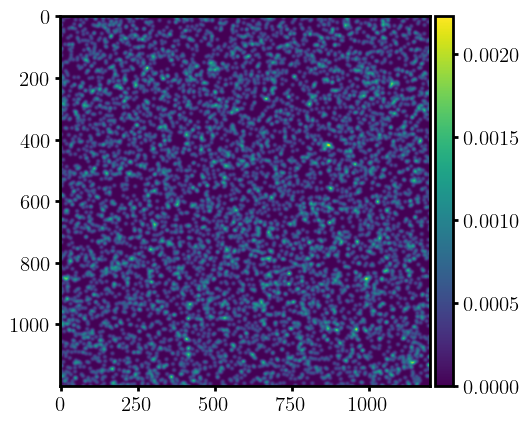

In [210]:
rand_tau = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4_image.fits')
im = plt.imshow(rand_tau)
colorbar(im)

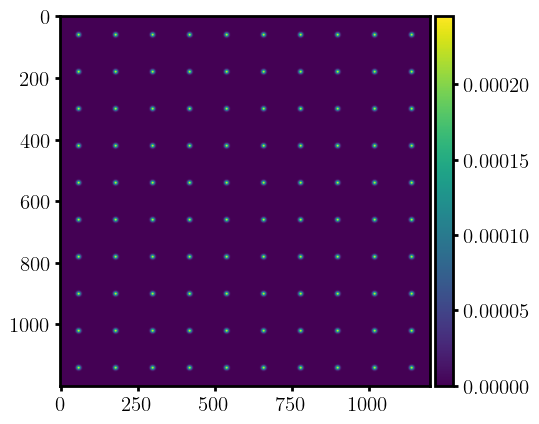

In [243]:
grid_tau = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/grid_10x10_10x10src_periodic_v2/grid_10x10_10x10src_periodic_v2_renorm2.45e-04_image.fits')
im = plt.imshow(grid_tau)
colorbar(im)

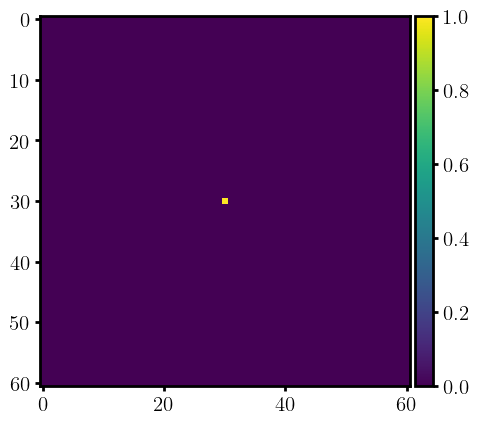

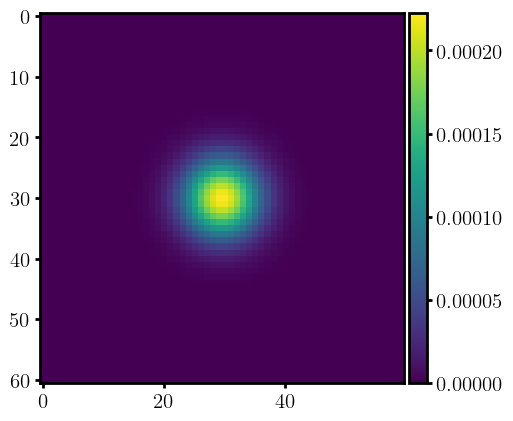

In [235]:
# compare to single source
baseMap, boxMask, wcs = make_basemap()
dmap = make_ptsrc_map(baseMap, plot=True)
gmap = gaussify_map(dmap, fwhm=5., plot=True)

In [244]:
print(np.sum(gmap.data))
print(np.sum(gmap.data) * 7659)
print(np.sum(cmass_tau))
print(np.sum(gmap.data) * 7666)
print(np.sum(rand_tau))
print(np.sum(gmap.data) * 100)
print(np.sum(grid_tau))

0.02748837733698474
210.53348202396612
415.26791240098123
210.725900665325
414.9018311875316
2.748837733698474
2.8781305215650788


# HEYO!

In [108]:
fwhm = 5.
sigma = fwhm / np.sqrt(8.*np.log(2))
denorm = 2. * np.pi * sigma**2
pixarea = 0.25 # approx
peaktau = 2.45e-4

In [109]:
print(denorm, 1/denorm, 1/(4*denorm))

28.327250886419964 0.03530169602442425 0.008825424006106062


414.70566853431853
103.67641713357963
2.878130521565079
0.7195326303912698
2.6155254000547568
0.6538813500136892


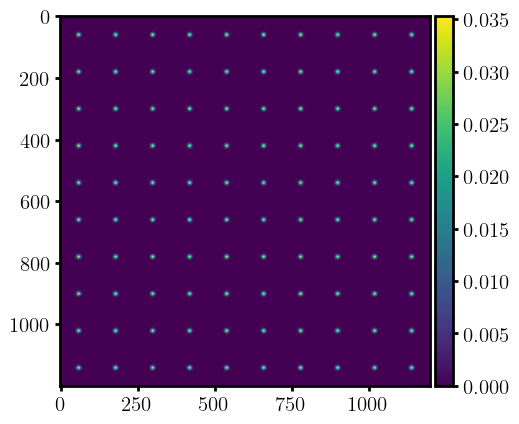

In [110]:
grid_tau_orig = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/grid_10x10_10x10src_periodic/mock_count_gauss_car.fits')
print(np.sum(grid_tau_orig))
print(np.sum(grid_tau_orig) * pixarea) #approximate pixel area in arcmin^2
print(np.sum(grid_tau_orig * denorm * peaktau))
print(np.sum(grid_tau_orig * denorm * peaktau * pixarea))
print(np.sum(gmap.data) * 100)
print(np.sum(gmap.data) * 100 * pixarea)
f = plt.figure()
im = plt.imshow(grid_tau_orig)
colorbar(im)

31660.731536654315
7915.182884163579
219.7310639441668
54.9327659860417
200.3230903901938
50.08077259754845


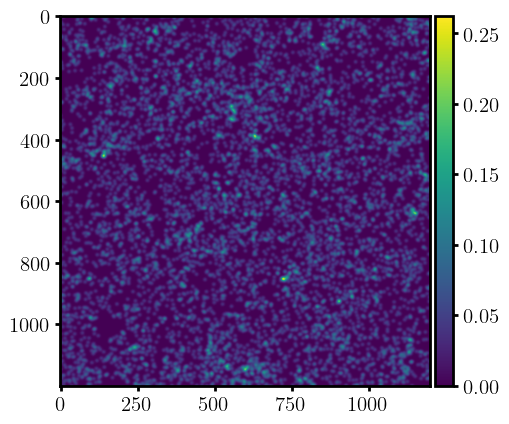

In [111]:
cmass_tau_orig = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/cmass_m_10x10_v2_fwhm5/mock_count_gauss_car.fits')
print(np.sum(cmass_tau_orig)) #[ct arcmin^-2]
print(np.sum(cmass_tau_orig) * pixarea) #approximate integrated number count by multiplying by approx pixel area in arcmin^2
print(np.sum(cmass_tau_orig * denorm * peaktau))
print(np.sum(cmass_tau_orig  * denorm * peaktau * pixarea))
print(np.sum(gmap.data) * 7659)
print(np.sum(gmap.data) * 7659 * pixarea)
f = plt.figure()
im = plt.imshow(cmass_tau_orig)
colorbar(im)

31632.82088265597
7908.205220663993
219.53735908010432
54.88433977002608
200.50617716819767
50.12654429204942


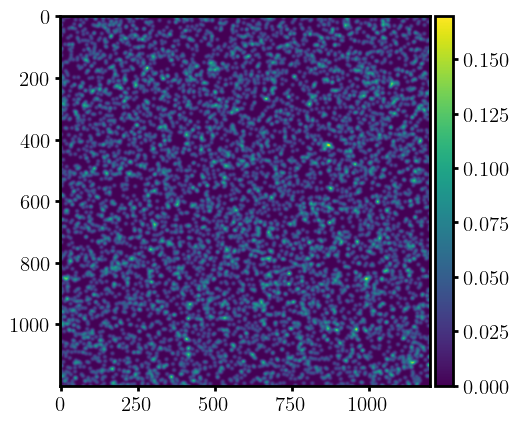

In [112]:
rand_tau_orig = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/cmass_m_10x10_sig5_randradec/mock_count_gauss_car.fits')
rand_tau_orig_renorm = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/cmass_m_10x10_sig5_randradec/mock_count_gauss_car_renorm2.45e-4_nobeam.fits')
print(np.sum(rand_tau_orig))
print(np.sum(rand_tau_orig) * pixarea) #approximate pixel area in arcmin^2
print(np.sum(rand_tau_orig * denorm * peaktau))
print(np.sum(rand_tau_orig * denorm * peaktau * pixarea))
print(np.sum(gmap.data) * 7666)
print(np.sum(gmap.data) * 7666 * 0.25)
f = plt.figure()
im = plt.imshow(rand_tau_orig)
colorbar(im)

414.9018311875316
103.7254577968829
2.8794919249946465
0.7198729812486616
200.50617716819767
50.12654429204942


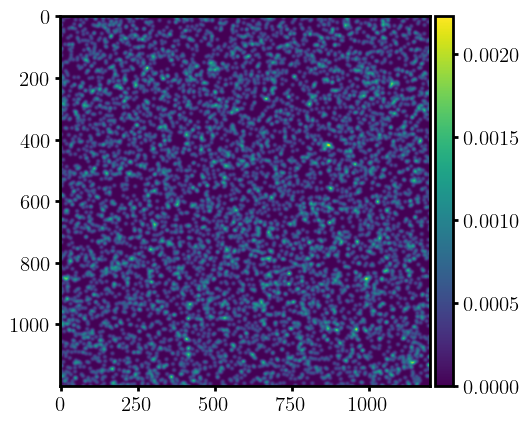

In [113]:
rand_tau_orig_renorm = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/cmass_m_10x10_sig5_randradec/mock_count_gauss_car_renorm2.45e-4_nobeam.fits')
print(np.sum(rand_tau_orig_renorm))
print(np.sum(rand_tau_orig_renorm) * pixarea) #approximate pixel area in arcmin^2
print(np.sum(rand_tau_orig_renorm * denorm * peaktau))
print(np.sum(rand_tau_orig_renorm * denorm * peaktau * pixarea))
print(np.sum(gmap.data) * 7666)
print(np.sum(gmap.data) * 7666 * 0.25)
f = plt.figure()
im = plt.imshow(rand_tau_orig_renorm)
colorbar(im)